In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import glob
import os
from skimage.feature import hog

## Loading Data and Unpacking

In [2]:
vehicles_file="vehicles.zip"
non_vehicles_file="non-vehicles.zip"


In [3]:
def unzip_data(file):
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall()
    print("unzip done...")
unzip_data(vehicles_file)
unzip_data(non_vehicles_file)

unzip done...
unzip done...


In [4]:
def set_vehicle_labels():
    return 0
def set_non_vehicle_labels():
    return 1

In [5]:
def load_data(path,label): ###path here means folder of the base class, label is class_label
    file= glob.glob(path + '/**/*.png')###because the image is under different folder
    
    
    ####define the output array
    image_number=len(file)
    x=np.zeros((image_number,)+(64,64,3),dtype=np.uint8)
    y=np.zeros((image_number,),dtype=int)
    
    ###read image
    for i in range(image_number):
        x[i]=cv2.imread(file[i])
        y[i]=label
        
    print("data loading....")
        
    return x,y  

In [6]:
vehicles, label_vehicles=load_data("./vehicles",set_vehicle_labels())
non_vehicles, label_non_vehicles=load_data("./non-vehicles",set_non_vehicle_labels())
Img=np.concatenate((vehicles,non_vehicles))
Labels=np.concatenate((label_vehicles,label_non_vehicles))

data loading....
data loading....


In [7]:
non_vehicles=non_vehicles[0:8792]

In [8]:
print("vehicles.shape:", vehicles.shape )
print("vehicles_label.shape",label_vehicles.shape)
print("non-vehicles.shape:", non_vehicles.shape) 
print("non_vehicles_label.shape",label_non_vehicles.shape)
print("Concatenate_img.shape:",Img.shape)######Concatenate_image is the final image set used for svm training
print("Label_shape:",Labels.shape)#####Concatenate_labels is the final label set
print("Image_range:",np.amin(Img),np.amax(Img))

vehicles.shape: (8792, 64, 64, 3)
vehicles_label.shape (8792,)
non-vehicles.shape: (8792, 64, 64, 3)
non_vehicles_label.shape (8968,)
Concatenate_img.shape: (17760, 64, 64, 3)
Label_shape: (17760,)
Image_range: 0 255


## Data Preprocessing and Augmentation


#### Prepare a balanced dataset, i.e., have as many positive as negative examples, or in the case of multi class,problems, roughly the same number of cases of each class 
#### Random Shuffling of the data
#### Splitting the data into a training and testing set
#### Normalization of features, typically to zero mean and unit variance

## Visualize vehicle and non-vehicle dataset

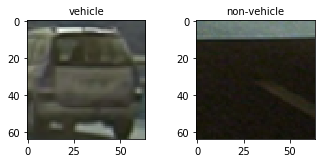

In [9]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(4,4))
f.tight_layout()
ax1.imshow(vehicles[0])
ax1.set_title("vehicle",fontsize=10)
ax2.imshow(non_vehicles[0])
ax2.set_title("non-vehicle",fontsize=10)
plt.subplots_adjust(left=0.,right=1, top=0.9,bottom=0.)

## Feature Extraction

In [10]:
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    

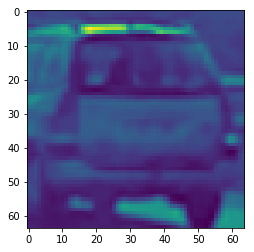

In [117]:
test_image=vehicles[0]

test_image=cv2.cvtColor(test_image,cv2.COLOR_RGB2GRAY)

plt.imshow(test_image)

In [118]:
features, hog_image = get_hog_features(test_image, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


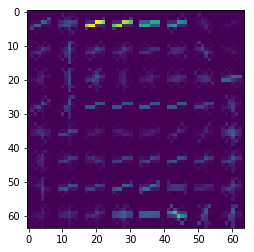

In [119]:
plt.imshow(hog_image)

In [14]:
### Color Histogram Features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [15]:
####
def bin_spatial(img,size=(32,32)):
    bin_spatial_features=cv2.resize(img, size).ravel()
    return bin_spatial_features

In [16]:
def convert_color_space(img,color_space='YCrCb'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            
    return feature_img

In [18]:
####define parameter_list dictionary
parameter_list={'orientation':9,
                'pixel_per_cell':8,
                'cell_per_block':2,
                'color_space':'YCrCb',          #Can be RGB, HSV, LUV, HLS, YUV, YCrCb
                'bin_spatial_size':(32,32),     #Spatial binning dimensions
                'hist_bins':16,                 #nbins, Number of histogram bins
                'hog_features':True,            #Flags for whether hog features or not
                'spatial_bin_features':True,    #Flags for whether spatial_bin features or not
                'color_histogram_features':True,#Flags for whether color_histogram_features or not 
                'hog_channel': 'All',           # Hog feature is based on 3 channel image or ???
                'resize_h':64,                  # resize image height before final_feature_extraction
                'resize_w':64                   # resize image height before final_feature_extraction
               }

In [19]:
def extract_features_from_single_image(image,parameter_list):
    """
    Extract and return the feature vector from given image.
    Parameters
    ----------
    image : ndarray
        input image on which perform feature extraction.
    feat_extraction_params : dict
        dictionary of parameters that control the process of feature extraction.
    Returns
    -------
    features : ndarray
        array of features which describes the input image.
    """
    
    ##Iniatilize input vector from parameter_list
    
    
    color_space=parameter_list['color_space']
    image_feature_tracking=convert_color_space(image,color_space) ###Convert color space
    
    hog_features=parameter_list['hog_features']
    spatial_bin_features=parameter_list['spatial_bin_features']
    color_histogram_features=parameter_list['color_histogram_features']
    nbins=parameter_list['hist_bins']
    bin_spatial_size=parameter_list['bin_spatial_size']
    orient=parameter_list['orientation']
    pixel_per_cell=parameter_list['pixel_per_cell']
    cell_per_block=parameter_list['cell_per_block']
    hog_channel=parameter_list['hog_channel']
    
    #Define image_feature list
    image_features=[]
    
    if color_histogram_features:
        color_hist_features=color_hist(image_feature_tracking,nbins=nbins,bins_range=(0,256))
        image_features.append(color_hist_features)
        
    if spatial_bin_features:
        spatial_bin_features=bin_spatial(image_feature_tracking,size=bin_spatial_size)
        image_features.append(spatial_bin_features)
        
        
    if hog_features:
        
        if hog_channel=='All':
            hog_features=[]
            for i in range(image_feature_tracking.shape[2]):
                hog=get_hog_features(image_feature_tracking[:,:,i],orient,pixel_per_cell,cell_per_block)
                hog_features.append(hog)
                
            hog_features = np.ravel(hog_features)
            
        else:
            
            hog=get_hog_features(image_feature_tracking[:,:,hog_channel],orient,pixel_per_cell,cell_per_block)
            hog_features.append(hog)
            
        image_features.append(hog_features)
        
    return np.concatenate(image_features)

In [126]:
def extract_features_from_whole_dataset(dataset_list,parameter_list):
    """
    Extract features from a list of images
    Parameters
    ----------
    file_list : list
        list of files path on which feature extraction process must be performed.
    feat_extraction_params : dict
        dictionary of parameters that control the process of feature extraction.
    Returns
    -------
    features : list
        list of feature array, one for each input file.
    """
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of image files
    for file in dataset_list:

        resize_h, resize_w = parameter_list['resize_h'], parameter_list['resize_w']
        image = cv2.resize(cv2.imread(file), (resize_w, resize_h))

        # compute the features of this particular image, then append to the list
        file_features = extract_features_from_single_image(image, parameter_list)
        features.append(file_features)

    return features
        
        

## Train SVM Classifier

In [22]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from os.path import splitext
from os.path import join
from os.path import dirname
from os.path import exists
import sys
import time
import pickle

In [6]:
def get_file_list_recursively(directory,allowed_extensions=[]):
    if not exists(directory):
        raise ValueError('Directory "{}" does not exist.'.format(directory))
        
    file_list=[]
    for cur_dir,cur_subdirs,cur_files in os.walk(directory):
        for file in cur_files:
            f_name,f_ext= splitext(file)
            if f_ext:
                if allowed_extensions and f_ext not in allowed_extensions:
                    pass
                else:
                    file_list.append(join(cur_dir,file))
                    sys.stdout.write('found {:06d} files...'.format(directory,len(file_list)))
                    sys.stdout.flush()
                    
            else:
                pass
            
        sys.stdout.write('Done.')
        
        return file_list
                                     

In [7]:
vehicles_path='/Users/likangning/NANODEGREE/term_1/project5_vehicle_detection/vehicles'
non_vehicles_path='/Users/likangning/NANODEGREE/term_1/project5_vehicle_detection/vehicles'

In [8]:
vehicles=get_file_list_recursively(vehicles_path)
non_vehicles=get_file_list_recursively(non_vehicles_path)

Done.Done.

In [128]:
car_features=extract_features_from_whole_dataset(vehicles,parameter_list)
non_car_features=extract_features_from_whole_dataset(non_vehicles,parameter_list)

TypeError: bad argument type for built-in operation

In [24]:
X= np.vstack((car_features,non_car_features)).astype(np.float64)

In [25]:
####Standardize feature
feature_scaler=StandardScaler().fit(X)
scaled_X=feature_scaler.transform(X)

In [26]:
#### Define the labels vector
y=np.hstack((np.ones(len(car_features)),np.zeros(len(non_car_features))))

In [27]:
rand_state=np.random.randint(0,100)
X_train, X_test, y_train, y_test=train_test_split(scaled_X,y,test_size=0.2,random_state=rand_state)

In [28]:
print(len(car_features))
print(len(non_car_features))

8792
8792


In [29]:
print("original_image_shape",scaled_X.shape)
print("Original_labes_shape",y.shape)
print("X_train.shape",X_train.shape)
print("X_test.shape",X_test.shape)

original_image_shape (17584, 3123)
Original_labes_shape (17584,)
X_train.shape (14067, 3123)
X_test.shape (3517, 3123)


In [30]:
#### Define the classifier
svc= LinearSVC()

In [31]:
####Train the classifier
t=time.time()
svc.fit(X_train,y_train)
t2=time.time()
print(round(t2-t,2),'Seconds to train SVC')


31.03 Seconds to train SVC


In [32]:
####Check the scores of svc
print("Accuracy of SVC=" ,round(svc.score(X_test,y_test),4))

Accuracy of SVC= 0.9451


In [33]:
#### dump all necessary stuffs
with open('data/svm_trained.pickle','wb') as f:
    pickle.dump(svc,f)
    
with open('data/feature_scaler.pickle','wb') as f:
    pickle.dump(feature_scaler,f)
    
with open('data/parameter_list.pickle','wb') as f:
    pickle.dump(parameter_list,f)

## Sliding Window Search

In [34]:
def draw_box(img,bboxes,color=(0,0,255),thick=6):
    imcopy=np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

In [35]:
def sliding_window(img,x_start_stop=[None,None],y_start_stop=[None,None],xy_window=(64,64),xy_overlap= (0.5,0.5)):
    ###if x and/or y start/stop positions not defined,set to image size
    if x_start_stop[0]==None:
        x_start_stop[0]= 0
    if x_start_stop[1]==None:
        x_start_stop[1]= img.shape[1]
    if y_start_stop[0]==None:
        y_start_stop[0]=0
    if y_start_stop[1]==None:
        y_start_stop[1]=img.shape[0]
        
    ##compute the span of region to be searched
    xspan=x_start_stop[1]-x_start_stop[0]
    yspan=y_start_stop[1]-y_start_stop[0]
    ##compute the number of windows in x/y
    
    nx_pix_per_step= np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step= np.int(xy_window[1]*(1-xy_overlap[1]))
    
    ###computer the number of windows in x/y
    nx_buffer= np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer= np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows= np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows= np.int((yspan-ny_buffer)/ny_pix_per_step)
    ####Initialize a list to append window position to 
    window_list=[]
    ####Loop through finding x and y window positions
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            ###calculate the window position
            startx=xs*nx_pix_per_step+x_start_stop[0]
            endx= startx+xy_window[0]
            starty=ys*ny_pix_per_step+y_start_stop[1]
            endy=starty+xy_window[1]
            
            
            window_list.append(((startx,starty),(endx,endy)))
            
            
    return window_list    

In [109]:
def search_windows(img,windows,clf,scaler,parameter_list):
    ####Predict whether each window has a car or not 
    on_windows=[]
    for window in windows:
        ###Extract the test window from original image
        test_img=cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
        test_img=cv2.resize(img[window[0][0]:window[1][0],window[0][1]:window[1][1]],(64,64))
        ###Extract feature for that window using single_img_features()
        features=extract_features_from_single_image(test_img,parameter_list)
        ###Scale extracted features to be fed to classifier
        test_features=scaler.transform(np.array(features).reshape(1,-1))
        ###predict using your classifier
        prediction=clf.predict(test_features)
        ###if positive then save the window
        if prediction==1:
            on_windows.append(window)
            
    return on_windows
        

In [37]:
def multiscale_window(img,visualize=False):
    window_multiscale=[]
    height,width,channel=img.shape
    
    window_32_32=sliding_window(x_start_stop=[None,None],y_start_stop=[None,None],xy_window=(32,32),xy_overlap=(0.5,0.5))
    window_multiscale.append(window_32_32)
    
    window_64_64=sliding_window(x_start_stop=[None,None],y_start_stop=[None,None],xy_window=(64,64),xy_overlap=(0.5,0.5))
    window_multiscale.append(window_64_64)
    
    window_128_128=sliding_window(x_start_stop=[None,None],y_start_stop=[None,None],xy_window=(128,128),xy_overlap=(0.5,0.5))
    window_multiscale.append(window_128_128)
    
    
    if visualize:
        window_32_32_image=np.copy(img)
        window_32_32_image=draw_box(window_32_32_image,window_32_32,color=(255,0,0),thickness=1)
        window_64_64_image=np.copy(window_32_32_image)
        window_64_64_image=draw_box(window_32_32_image,window_64_64,color=(125,125,125),thickness=1)
        window_128_128_image=np.copy(window_64_64_image)
        window_128_128_image=draw_box(window_64_64_image,window_128_128,color=(75,75,75),thickness=1)
        
        plt.imshow(window_128_128_image)
    return np.concatenate(window_multiscale)
    

In [38]:
print(parameter_list)

{'bin_spatial_size': (32, 32), 'resize_h': 64, 'spatial_bin_features': True, 'resize_w': 64, 'hist_bins': 16, 'orientation': 9, 'color_histogram_features': True, 'hog_channel': 'All', 'hog_features': True, 'color_space': 'YCrCb', 'pixel_per_cell': 8, 'cell_per_block': 2}


In [39]:
test_img=vehicles[0]
test_img_=test_img.astype(np.float32)/255


In [78]:
ystart=400
ystop=656
scale=1.5

In [40]:
def find_cars(img,ystart,ystop,scale,svc,X_scaler,parameter_list,visualize=False):
    orient=parameter_list['orientation']
    pix_per_cell=parameter_list['pixel_per_cell']
    cell_per_block=parameter_list['cell_per_block']
    spatial_size=parameter_list['bin_spatial_size']
    hist_bins=parameter_list['hist_bins']
    color_space=parameter_list['color_space']
    #### Parameters weiter erklären
    """
    Extract features from the input image using hog sub_sampling and make predictions
    paremeters:
    img:ndarray..
    ystart,ystop: region after crop
                  within this region i want to perform sliding window search
    scale ....?? float: factor used to subsample the image before feature extraction
    svc: pre-trained svm classifier
    parameter_list:predifined parameter dictionary.
    
    
    return: hot_window:list  list of bounding box(defined by top-left and bottom-right corners)
    """
    draw_img=np.copy(img)
    hot_windows=[]
    img= img.astype(np.float32)/255
    
    img_tosearch=img[ystart:ystop,:,:]
    ctrans_tosearch=convert_color_space(img_tosearch,color_space=color_space)
    if scale !=1:
        imshape=ctrans_tosearch.shape
        ctrans_tosearch=cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale),np.int(im.shape[0]/scale)))
        
    ch1=ctrans_tosearch[:,:,0]
    ch2=ctrans_tosearch[:,:,1]
    ch3=ctrans_tosearch[:,:,2]
    
    ##define blocks and steps as above:
    nxblocks=(ch1.shape[1]//pix_per_cell)-cell_per_block+1
    nyblocks=(ch1.shape[0]//pix_per_cell)-cell_per_block+1
    
    ##64 was the original sampling rate, with 8 cells and 8 pix per cell
    window=64
    nblocks_per_window=(window//pix_per_cell)-cell_per_block+1
    
    cells_per_step=2 ##instead of overlap, define how many cells to step
    nxsteps=(nxblocks-nblocks_per_window)//cells_per_step+1
    nysteps=(nyblocks-nblocks_per_window)//cells_per_step+1
    
    ##Compute individual channel hog features for the entire image
    hog1= get_hog_features(ch1,orient,pix_per_cell,cell_per_block,feature_vec=False)
    hog2= get_hog_features(ch2,orient,pix_per_cell,cell_per_block,feature_vec=False)
    hog3= get_hog_features(ch3,orient,pix_per_cell,cell_per_block,feature_vec=False)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos=yb*cells_per_step
            xpos=xb*cells_per_step
            
            #Extract HOG for this patch
            hog_feat1=hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat2=hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat3=hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            
            hog_features=np.hstack(hog_feat1,hog_feat2,hog_feat3)
            
            xleft=xpos*pix_per_cell
            ytop=ypos*pix_per_cell
            
            #Extract the image patch
            subimg=cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window],(64,64))
            #Get color feature
            spatial_features=bin_spatial(subimg,size=spatial_size)
            hist_features=color_hist(subimg,nbins=hist_bins)
            #Scale feature and make a prediction
            test_features=X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))
            test_prediction=svc.predict(test_features)
            
            if test_prediction==1:
                xbox_left=np.int(xleft*scale)
                ytop_draw=np.int(ytop*scale)
                win_draw=np.int(window*scale)
                tl_corner_draw=(xbox_left,ytop_draw+ystart)
                br_corner_draw=(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                hot_windows.append((tl_corner_draw,br_corner_draw))
                
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
                
        if visualize:
            plt.imshow(draw_img)
            
        return hot_windows

In [101]:
svc=pickle.load(open('data/svm_trained.pickle','rb'))
feature_scaler=pickle.load(open('data/feature_scaler.pickle','rb'))
parameter_list=pickle.load(open('data/parameter_list.pickle','rb'))

### Heat Map for false positive

In [41]:
from scipy.ndimage.measurements import label

In [94]:
def add_heatmap(image,hot_windows,threshold=5,visualize=False):
    heatmap=np.zeros_like(image[:,:,0]).astype(np.float)
    for bbox in hot_windows:
        xmin,ymin=bbox[0]
        xmax,ymax=bbox[1]
        heatmap[ymin:ymax,xmin:xmax]+=1
        
    heatmap[heatmap<=threshold]=0
    labels=label(heatmap)
    
    return heatmap,labels
        
        
    

In [42]:
def add_heatmap_update(img,hot_windows,threshold=5,visualize= False):
    h,w,c=img.shape
    heatmap=np.zeros(shape=(h,w),dtype=uint8)
    for bbox in hot_windows:
        xmin,ymin=bbox[0]
        xmax,ymax=bbox[1]
        heatmap[ymin:ymax,xmin:xmax]+=1
    ###apply threshold and morphological closure to remove noise
    _, heatmap_thresh=cv2.threshold(heatmap,threshold,255,type=cv2.THRESH_BINARY)
    heatmap_thresh=cv2.morphologyEx(heatmap_thresh,op=cv2.MORPH_CLOSE,kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13)),iterations=1)
    
    
    if visualize:
        f,ax=plt.subplot(1,3)
        ax[0].imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        ax[1].imshow(heatmap,cmap='hot')
        ax[2].imshow(heatmap_thresh,cmap='hot')
        plt.show()
    return heatmap,heatmap_thresh
    

In [43]:
def draw_labeled_bounding_boxes_update(img,labeled_frame,num_objects):
    for car_number in range(1,num_objects+1):
        rows,cols=np.where(labeled_frame==car_number)
        x_min,y_min=np.min(cols),np.min(rows)
        x_max,y_max=np.max(cols),np.max(rows)
        cv2.rectangle(img,(x_min,y_min),(x_max,y_max),color=(255,0,0),thickness=6)
        
    return img

In [44]:
def draw_labeled_bboxes(img,labels):
    for car_number in range(1,labels[1]+1):
        nonzero=(labels[0]==car_number).nonzero()
        nonzeroy=np.array(nonzero[0])
        nonzerox=np.array(nonzero[1])
        bbox= ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
        
    return img
    

In [45]:
def pretty_output_frames(frame, img_hot_windows, img_heatmap, img_labeling, img_detection):
    h,w,c=frame.shape
    ###decide the size of thumbnail region
    thumb_ratio=0.25
    thumb_h,thumb_w=int(thumb_ratio*h),int(thumb_ratio*w)
    
    ###Resize to thumbnail images from various stages of the pipeline
    thumb_hot_windows=cv2.resize(img_hot_windows,dsize=(thumb_w,thumb_h))
    thumb_heatmap=cv2.resize(img_heatmap,dsize=(thumb_w,thumb_h))
    thumb_labeling=cv2.resize(img_labeling,dsize=(thumb_w,thumb_h))
    
    off_x,off_y=20,45
    
    ##add a semi-transparent ractangle to highlight thumbnails on the left
    mask=cv2.rectangle(img_detection.copy(),(0,0),(2*off_x+thumb_w,h),(0,0,0),thickness=cv2.FILLED)
    img_pretty=cv2.addWeighted(src1=mask,alpha=0.2,src2=img_detection,beta=0.8,gamma=0)
    
    ###Stich together
    img_pretty[off_y:off_y+thumb_h,off_x:off_x+thumb_w,:]=thumb_hot_windows
    img_pretty[2*off_y+thumb_h:2*(off_y+thumb_h),off_x:off_x+thumb_w,:]=thumb_heatmap
    img_pretty[3*off_y+thumb_h:3*(off_y+thumb_h),off_x:off_x+thumb_w,:]=thumb_labeling
    
    return img_pretty
    

In [46]:
def normalize_image(img):
    img=np.float32(img)
    img=img/img.max()*255
    return np.uint8(img)

In [47]:
def pipeline(frame,svc,feature_scaler,parameter_list,keep_state=True,visualize=False):
    hot_windows=[]
    for scale in np.arrange(1,3,0.5):
        hot_windows+= find_cars(frame,400,656,scale,svc,feature_scaler,parameter_list)
        
    if keep_state:
        hot_windows=np.concatenate(hot_windows)
        
    ##compute heatmap:
    threshold=5
    heatmap,heat_thresh=add_heatmap_update(frame,hot_windows,color=(0,0,255),thickness=2)
    labeled_frame,num_objects=scipy.ndimage.measurements.label(heat_thresh)
    
    ###prepare image for output
    img_hot_windows=draw_box(frame,hot_windows,color=(0,0,255),thickness=2) ###show pos windows
    img_heatmap=cv2.applyColorMap(normalize_image(heatmap),colormap=cv2.COLORMAP_HOT)
    img_labeling=cv2.applyColorMap(normalize_image(labeled_frame),colormap=cv2.COLORMAP_HOT)
    img_detection=draw_labeled_bounding_boxes_update(frame.copy(),labeled_frame,num_objects)
    
    img_output=pretty_output_frames(frame,img_hot_windows,img_heatmap,img_labeling,img_detection)
    
    if visualize:
        cv2.imshow("detection bboxes",img_hot_windows)
        cv2.imshow("heatmap",img_heatmap)
        cv2.imshow("labeled_frame",img_labeling)
        cv2.imshow("detection",img_detection)
        
    return img_output
    
    
    

In [99]:
test_image=cv2.imread('./test_images/test1.jpg')

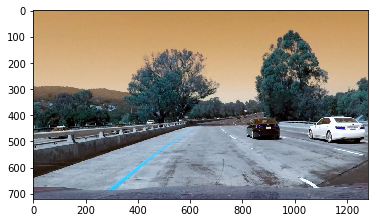

In [100]:
plt.imshow(test_image)

In [102]:
print(test_image.shape)

(720, 1280, 3)


In [66]:
h, w, c = test_image.shape
draw_image = np.copy(test_image)

In [105]:
window_list=sliding_window(test_image,x_start_stop=[0,1280],y_start_stop=[h//2,720],xy_window=(64,64),xy_overlap= (0.5,0.5))

In [106]:
print(window_list)

[((0, 720), (64, 784)), ((32, 720), (96, 784)), ((64, 720), (128, 784)), ((96, 720), (160, 784)), ((128, 720), (192, 784)), ((160, 720), (224, 784)), ((192, 720), (256, 784)), ((224, 720), (288, 784)), ((256, 720), (320, 784)), ((288, 720), (352, 784)), ((320, 720), (384, 784)), ((352, 720), (416, 784)), ((384, 720), (448, 784)), ((416, 720), (480, 784)), ((448, 720), (512, 784)), ((480, 720), (544, 784)), ((512, 720), (576, 784)), ((544, 720), (608, 784)), ((576, 720), (640, 784)), ((608, 720), (672, 784)), ((640, 720), (704, 784)), ((672, 720), (736, 784)), ((704, 720), (768, 784)), ((736, 720), (800, 784)), ((768, 720), (832, 784)), ((800, 720), (864, 784)), ((832, 720), (896, 784)), ((864, 720), (928, 784)), ((896, 720), (960, 784)), ((928, 720), (992, 784)), ((960, 720), (1024, 784)), ((992, 720), (1056, 784)), ((1024, 720), (1088, 784)), ((1056, 720), (1120, 784)), ((1088, 720), (1152, 784)), ((1120, 720), (1184, 784)), ((1152, 720), (1216, 784)), ((1184, 720), (1248, 784)), ((12

In [111]:
windows=[((728, 400), (792, 464)), ((760, 400), (824, 464)), ((792, 400), (856, 464)), ((824, 400), (888, 464)), ((856, 400), (920, 464)), ((888, 400), (952, 464)), ((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((984, 400), (1048, 464)), ((1016, 400), (1080, 464)), ((1048, 400), (1112, 464)), ((1080, 400), (1144, 464)), ((1112, 400), (1176, 464)), ((1144, 400), (1208, 464)), ((1176, 400), (1240, 464)), ((1208, 400), (1272, 464)), ((760, 432), (824, 496)), ((792, 432), (856, 496)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((920, 432), (984, 496)), ((952, 432), (1016, 496)), ((984, 432), (1048, 496)), ((1016, 432), (1080, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((760, 464), (824, 528)), ((792, 464), (856, 528)), ((824, 464), (888, 528)), ((856, 464), (920, 528)), ((888, 464), (952, 528)), ((920, 464), (984, 528)), ((952, 464), (1016, 528)), ((984, 464), (1048, 528)), ((1016, 464), (1080, 528)), ((1048, 464), (1112, 528)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528)), ((1144, 464), (1208, 528)), ((1176, 464), (1240, 528)), ((1208, 464), (1272, 528)), ((792, 496), (856, 560)), ((824, 496), (888, 560)), ((856, 496), (920, 560)), ((888, 496), (952, 560)), ((920, 496), (984, 560)), ((952, 496), (1016, 560)), ((984, 496), (1048, 560)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560)), ((1112, 496), (1176, 560)), ((1144, 496), (1208, 560)), ((1176, 496), (1240, 560)), ((1208, 496), (1272, 560)), ((824, 528), (888, 592)), ((856, 528), (920, 592)), ((888, 528), (952, 592)), ((920, 528), (984, 592)), ((952, 528), (1016, 592)), ((984, 528), (1048, 592)), ((1016, 528), (1080, 592)), ((1048, 528), (1112, 592)), ((1080, 528), (1144, 592)), ((1112, 528), (1176, 592)), ((1144, 528), (1208, 592)), ((1176, 528), (1240, 592)), ((1208, 528), (1272, 592)), ((856, 560), (920, 624)), ((888, 560), (952, 624)), ((920, 560), (984, 624)), ((952, 560), (1016, 624)), ((984, 560), (1048, 624)), ((1016, 560), (1080, 624)), ((1048, 560), (1112, 624)), ((1080, 560), (1144, 624)), ((1112, 560), (1176, 624)), ((1144, 560), (1208, 624)), ((1176, 560), (1240, 624)), ((1208, 560), (1272, 624)), ((888, 592), (952, 656)), ((920, 592), (984, 656)), ((952, 592), (1016, 656)), ((984, 592), (1048, 656)), ((1016, 592), (1080, 656)), ((1048, 592), (1112, 656)), ((1080, 592), (1144, 656)), ((1112, 592), (1176, 656)), ((1144, 592), (1208, 656)), ((1176, 592), (1240, 656)), ((1208, 592), (1272, 656)), ((920, 624), (984, 688)), ((952, 624), (1016, 688)), ((984, 624), (1048, 688)), ((1016, 624), (1080, 688)), ((1048, 624), (1112, 688)), ((1080, 624), (1144, 688)), ((1112, 624), (1176, 688)), ((1144, 624), (1208, 688)), ((1176, 624), (1240, 688)), ((1208, 624), (1272, 688)), ((952, 656), (1016, 720)), ((984, 656), (1048, 720)), ((1016, 656), (1080, 720)), ((1048, 656), (1112, 720)), ((1080, 656), (1144, 720)), ((1112, 656), (1176, 720)), ((1144, 656), (1208, 720)), ((1176, 656), (1240, 720)), ((1208, 656), (1272, 720))]

In [115]:
window_img=draw_box(test_image,windows,color=(255,0,0),thick=6)

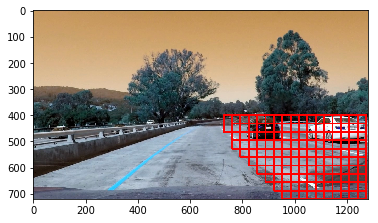

In [116]:
plt.imshow(window_img)

In [114]:
windows=[((728, 400), (792, 464)), ((760, 400), (824, 464)), ((792, 400), (856, 464)), ((824, 400), (888, 464)), ((856, 400), (920, 464)), ((888, 400), (952, 464)), ((920, 400), (984, 464)), ((952, 400), (1016, 464)), ((984, 400), (1048, 464)), ((1016, 400), (1080, 464)), ((1048, 400), (1112, 464)), ((1080, 400), (1144, 464)), ((1112, 400), (1176, 464)), ((1144, 400), (1208, 464)), ((1176, 400), (1240, 464)), ((1208, 400), (1272, 464)), ((760, 432), (824, 496)), ((792, 432), (856, 496)), ((824, 432), (888, 496)), ((856, 432), (920, 496)), ((888, 432), (952, 496)), ((920, 432), (984, 496)), ((952, 432), (1016, 496)), ((984, 432), (1048, 496)), ((1016, 432), (1080, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((760, 464), (824, 528)), ((792, 464), (856, 528)), ((824, 464), (888, 528)), ((856, 464), (920, 528)), ((888, 464), (952, 528)), ((920, 464), (984, 528)), ((952, 464), (1016, 528)), ((984, 464), (1048, 528)), ((1016, 464), (1080, 528)), ((1048, 464), (1112, 528)), ((1080, 464), (1144, 528)), ((1112, 464), (1176, 528)), ((1144, 464), (1208, 528)), ((1176, 464), (1240, 528)), ((1208, 464), (1272, 528)), ((792, 496), (856, 560)), ((824, 496), (888, 560)), ((856, 496), (920, 560)), ((888, 496), (952, 560)), ((920, 496), (984, 560)), ((952, 496), (1016, 560)), ((984, 496), (1048, 560)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560)), ((1112, 496), (1176, 560)), ((1144, 496), (1208, 560)), ((1176, 496), (1240, 560)), ((1208, 496), (1272, 560)), ((824, 528), (888, 592)), ((856, 528), (920, 592)), ((888, 528), (952, 592)), ((920, 528), (984, 592)), ((952, 528), (1016, 592)), ((984, 528), (1048, 592)), ((1016, 528), (1080, 592)), ((1048, 528), (1112, 592)), ((1080, 528), (1144, 592)), ((1112, 528), (1176, 592)), ((1144, 528), (1208, 592)), ((1176, 528), (1240, 592)), ((1208, 528), (1272, 592)), ((856, 560), (920, 624)), ((888, 560), (952, 624)), ((920, 560), (984, 624)), ((952, 560), (1016, 624)), ((984, 560), (1048, 624)), ((1016, 560), (1080, 624)), ((1048, 560), (1112, 624)), ((1080, 560), (1144, 624)), ((1112, 560), (1176, 624)), ((1144, 560), (1208, 624)), ((1176, 560), (1240, 624)), ((1208, 560), (1272, 624)), ((888, 592), (952, 656)), ((920, 592), (984, 656)), ((952, 592), (1016, 656)), ((984, 592), (1048, 656)), ((1016, 592), (1080, 656)), ((1048, 592), (1112, 656)), ((1080, 592), (1144, 656)), ((1112, 592), (1176, 656)), ((1144, 592), (1208, 656)), ((1176, 592), (1240, 656)), ((1208, 592), (1272, 656)), ((920, 624), (984, 688)), ((952, 624), (1016, 688)), ((984, 624), (1048, 688)), ((1016, 624), (1080, 688)), ((1048, 624), (1112, 688)), ((1080, 624), (1144, 688)), ((1112, 624), (1176, 688)), ((1144, 624), (1208, 688)), ((1176, 624), (1240, 688)), ((1208, 624), (1272, 688)), ((952, 656), (1016, 720)), ((984, 656), (1048, 720)), ((1016, 656), (1080, 720)), ((1048, 656), (1112, 720)), ((1080, 656), (1144, 720)), ((1112, 656), (1176, 720)), ((1144, 656), (1208, 720)), ((1176, 656), (1240, 720)), ((1208, 656), (1272, 720))]